In [1]:
import os
import json
import pandas as pd
import numpy as np
import json

from matplotlib import pyplot as plt
import seaborn as sb

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar

In [2]:
sb.set_style("darkgrid")
sb.set_context("paper",  font_scale = 1,
               rc={
                   "grid.linewidth": 3.75,
                   'axes.labelsize': 28,
                   "axes.titlesize": 32,
                   "legend.fontsize": 28.0,
                   'lines.linewidth': 5,
                   'xtick.labelsize': 24.0,
                   'ytick.labelsize': 24.0,
               })
current_palette = list(sb.color_palette())
colors = {
    'RL': current_palette[0],
    'RR': current_palette[5],
    'SOP':current_palette[4],
    'RAND':current_palette[7],
    'optimal':current_palette[1],
    '0':current_palette[-2],
    '1':current_palette[-1]
}

In [3]:
# Load in split map from saved json files.
# With new kfold-cv splits this is not necessary as we have one file that directly contains the map.


data_dir = "/home/biedenka/git/rl-plan/experiments/assembly_v3"

split_map = {}

with open(os.path.join(data_dir, 'assembly-crossvalidation', 'splits.json')) as fh:
    split_map = json.load(fh)
string_keys = list(split_map.keys())
for key in string_keys:
    split_map[int(key)] = {}
    for t in split_map[key]:
        split_map[int(key)][t] = list(map(lambda x: os.path.basename(x), split_map[key][t]))

In [4]:
# Load the validated RL data
exp_dir = '/home/biedenka/git/rl-plan'
rl_data = {}
rl_time_data = {}

UNITS = 200
cutoff = 7500  # used cutoff for all experiments
for TEST in [True, False]:  # For all trining and test splits
    print('TEST ', TEST)
    rl_cost = {}
    rl_traj = {}
    rl_tims = {}
    rl_times = {}
    for split in range(1, 6):
        print('SPLIT %d' % split)
        timeouts = 0
        means = []
        trajs = []
        timouts = []
        times = []
        for seed in range(1, 11):  # for all 10 seeds
            try:
                file=os.path.join(
                    data_dir,
                    'old_feats_wide_long_%d_full_train_set_2-%d-%d-split%d' % (
                        split, UNITS, seed, split),
                    'best',
                    '%s-2-%d-split%d-seed%d.json' % (
                        'test' if TEST else 'train', UNITS, split, seed))
#                 print(file)
                with open(file, 'r') as fh:
                    data = json.load(fh)
        #         print(data)
                for traj in data['trajectories']:  # load the trajectories and see if they match the cutoff
        #             print(len(traj))
                    if len(traj) >= cutoff:
                        timeouts += 1
                means.append(data['mean'])         # load the average plan cost over all 22/24 training or 8/6 test instances
                trajs.append(data['trajectories']) # load all policies for runs on all 22/24 / 8/6 instances
                timouts.append(timeouts)
                times.append(data['times_per_episode'])
            except FileNotFoundError:
                print('Not done with split %d seed %d' % (split, seed))

        # Compute the mean and stdev over 10 repetitions
        rl_cost[split] = (np.mean(means), np.std(means))
        rl_traj[split] = trajs
        rl_tims[split] = np.ceil(np.mean(timouts))
        rl_times[split] = times

        print('{:^7s} | {:^7s} | {:s}'.format('Mean', 'Stdev', 'Timeouts'))
        print('{:>+7.2f} | {:>+7.2f} | {:>1.1f}'.format(*rl_cost[split],
                                                        rl_tims[split]))
        print('#'*90)

    print('Done')

    if TEST:
        rl_data['test'] = (rl_cost, rl_traj, rl_tims)
        rl_time_data['test'] = rl_times
    else:
        rl_data['train'] = (rl_cost, rl_traj, rl_tims)
        rl_time_data['train'] = rl_times

TEST  True
SPLIT 1
 Mean   |  Stdev  | Timeouts
-347.42 | +365.34 | 1.0
##########################################################################################
SPLIT 2
 Mean   |  Stdev  | Timeouts
-790.70 |   +3.82 | 0.0
##########################################################################################
SPLIT 3
 Mean   |  Stdev  | Timeouts
-126.50 |   +9.23 | 0.0
##########################################################################################
SPLIT 4
 Mean   |  Stdev  | Timeouts
-291.65 |  +81.57 | 0.0
##########################################################################################
SPLIT 5
 Mean   |  Stdev  | Timeouts
-273.23 |  +25.77 | 0.0
##########################################################################################
Done
TEST  False
SPLIT 1
 Mean   |  Stdev  | Timeouts
-307.85 |  +30.00 | 0.0
##########################################################################################
SPLIT 2
 Mean   |  Stdev  | Timeouts
-169.52 |   +7.70 | 0.0

In [5]:
# Remap the results according to training and test splits. I.e. average plan cost
# given the policy on instance inst/idx in split split
train_results = {}
test_results = {}
train_time_results = {}
test_time_results = {}
for split in range(1, 6):
    train_insts = split_map[split]['train']
    test_insts = split_map[split]['test']
    for idx, inst in enumerate(train_insts):
        if inst not in train_results:
            train_results[inst] = []
            train_time_results[inst] = []
        plan_lens = []
        times = []
        for seed in range(10): # get plan cost from the saved trajectory
            plan_lens.append(len(rl_data['train'][1][split][seed][idx]))
            times.append(rl_time_data['train'][split][seed][idx])
        train_results[inst].append(np.mean(plan_lens))
        train_time_results[inst].append(np.mean(times))
    for idx, inst in enumerate(test_insts):
        if inst not in test_results:
            test_results[inst] = []
            test_time_results[inst] = []
        plan_lens = []
        for seed in range(10):
            plan_lens.append(len(rl_data['test'][1][split][seed][idx]))
            times.append(rl_time_data['test'][split][seed][idx])
        test_results[inst].append(np.mean(plan_lens))
        test_time_results[inst].append(np.mean(times))

In [6]:
# Getting the average over the training/test runs
# print(json.dumps(test_results, indent=4, sort_keys=True))
average_rl_test_results = {}
average_rl_times_test = {}
for inst in sorted(test_results.keys()):
    average_rl_test_results[inst] = np.mean(test_results[inst])
    average_rl_times_test[inst] = np.mean(test_time_results[inst])
print(json.dumps(average_rl_test_results, indent=4, sort_keys=True))
# print(json.dumps(train_results, indent=4, sort_keys=True))
average_rl_train_results = {}
average_rl_times_train = {}
for inst in sorted(train_results.keys()):
    average_rl_train_results[inst] = np.mean(train_results[inst])
    average_rl_times_train[inst] = np.mean(train_time_results[inst])
print(json.dumps(average_rl_train_results, indent=4, sort_keys=True))

{
    "prob01.pddl": 33.4,
    "prob02.pddl": 39.4,
    "prob03.pddl": 77.0,
    "prob04.pddl": 42.5,
    "prob05.pddl": 57.3,
    "prob06.pddl": 37.5,
    "prob07.pddl": 1099.4,
    "prob08.pddl": 71.9,
    "prob09.pddl": 153.1,
    "prob10.pddl": 68.4,
    "prob11.pddl": 124.8,
    "prob12.pddl": 64.6,
    "prob13.pddl": 128.2,
    "prob14.pddl": 181.7,
    "prob15.pddl": 143.7,
    "prob16.pddl": 107.8,
    "prob17.pddl": 99.9,
    "prob18.pddl": 4128.3,
    "prob19.pddl": 281.8,
    "prob20.pddl": 171.1,
    "prob21.pddl": 95.8,
    "prob22.pddl": 319.1,
    "prob23.pddl": 171.4,
    "prob24.pddl": 164.5,
    "prob25.pddl": 282.5,
    "prob26.pddl": 1008.4,
    "prob27.pddl": 1102.6,
    "prob28.pddl": 242.5,
    "prob29.pddl": 315.9,
    "prob30.pddl": 162.5
}
{
    "prob01.pddl": 32.075,
    "prob02.pddl": 41.025000000000006,
    "prob03.pddl": 77.5,
    "prob04.pddl": 40.400000000000006,
    "prob05.pddl": 53.5,
    "prob06.pddl": 38.0,
    "prob07.pddl": 122.25,
    "prob08.pdd

In [7]:
average_rl_train_results

{'prob01.pddl': 32.075,
 'prob02.pddl': 41.025000000000006,
 'prob03.pddl': 77.5,
 'prob04.pddl': 40.400000000000006,
 'prob05.pddl': 53.5,
 'prob06.pddl': 38.0,
 'prob07.pddl': 122.25,
 'prob08.pddl': 59.825,
 'prob09.pddl': 153.175,
 'prob10.pddl': 65.94999999999999,
 'prob11.pddl': 127.57500000000002,
 'prob12.pddl': 66.875,
 'prob13.pddl': 135.97500000000002,
 'prob14.pddl': 156.57500000000002,
 'prob15.pddl': 145.225,
 'prob16.pddl': 113.875,
 'prob17.pddl': 102.675,
 'prob18.pddl': 4028.65,
 'prob19.pddl': 268.675,
 'prob20.pddl': 168.39999999999998,
 'prob21.pddl': 85.67500000000001,
 'prob22.pddl': 321.725,
 'prob23.pddl': 167.95,
 'prob24.pddl': 162.1,
 'prob25.pddl': 256.025,
 'prob26.pddl': 733.275,
 'prob27.pddl': 279.875,
 'prob28.pddl': 241.375,
 'prob29.pddl': 321.525,
 'prob30.pddl': 168.15}

In [8]:
np.mean(list(average_rl_train_results.values()))

291.1958333333333

In [9]:
average_rl_test_results

{'prob01.pddl': 33.4,
 'prob02.pddl': 39.4,
 'prob03.pddl': 77.0,
 'prob04.pddl': 42.5,
 'prob05.pddl': 57.3,
 'prob06.pddl': 37.5,
 'prob07.pddl': 1099.4,
 'prob08.pddl': 71.9,
 'prob09.pddl': 153.1,
 'prob10.pddl': 68.4,
 'prob11.pddl': 124.8,
 'prob12.pddl': 64.6,
 'prob13.pddl': 128.2,
 'prob14.pddl': 181.7,
 'prob15.pddl': 143.7,
 'prob16.pddl': 107.8,
 'prob17.pddl': 99.9,
 'prob18.pddl': 4128.3,
 'prob19.pddl': 281.8,
 'prob20.pddl': 171.1,
 'prob21.pddl': 95.8,
 'prob22.pddl': 319.1,
 'prob23.pddl': 171.4,
 'prob24.pddl': 164.5,
 'prob25.pddl': 282.5,
 'prob26.pddl': 1008.4,
 'prob27.pddl': 1102.6,
 'prob28.pddl': 242.5,
 'prob29.pddl': 315.9,
 'prob30.pddl': 162.5}

In [10]:
np.mean(list(average_rl_test_results.values()))

365.9

In [11]:
average_rl_times_train

{'prob01.pddl': 0.052529472112655635,
 'prob02.pddl': 0.05767650008201599,
 'prob03.pddl': 0.21007710099220275,
 'prob04.pddl': 0.072380930185318,
 'prob05.pddl': 0.10214258432388307,
 'prob06.pddl': 0.05916326642036439,
 'prob07.pddl': 0.33665093779563904,
 'prob08.pddl': 0.09706292748451233,
 'prob09.pddl': 0.32340245842933657,
 'prob10.pddl': 0.12955390214920043,
 'prob11.pddl': 0.33390606641769405,
 'prob12.pddl': 0.22183848619461058,
 'prob13.pddl': 0.28275113105773925,
 'prob14.pddl': 0.4345983445644379,
 'prob15.pddl': 0.5222525119781494,
 'prob16.pddl': 0.5412618041038513,
 'prob17.pddl': 0.39518705010414124,
 'prob18.pddl': 79.57661635279655,
 'prob19.pddl': 0.9848650515079498,
 'prob20.pddl': 1.1512069165706635,
 'prob21.pddl': 0.5680759429931641,
 'prob22.pddl': 1.943015468120575,
 'prob23.pddl': 0.7466258108615874,
 'prob24.pddl': 1.23784259557724,
 'prob25.pddl': 2.3042491614818577,
 'prob26.pddl': 5.096286976337432,
 'prob27.pddl': 2.4834688305854797,
 'prob28.pddl': 1.79

In [12]:
average_rl_times_test

{'prob01.pddl': 0.46372673511505125,
 'prob02.pddl': 1.6412803769111632,
 'prob03.pddl': 0.5771680235862732,
 'prob04.pddl': 0.3352047840754191,
 'prob05.pddl': 0.5061371564865113,
 'prob06.pddl': 0.5008665919303894,
 'prob07.pddl': 1.9289724747339885,
 'prob08.pddl': 1.4761875033378602,
 'prob09.pddl': 1.2036338567733764,
 'prob10.pddl': 1.2078340196609496,
 'prob11.pddl': 0.4947273333867391,
 'prob12.pddl': 0.40057589213053385,
 'prob13.pddl': 0.31773942708969116,
 'prob14.pddl': 0.5000416815280915,
 'prob15.pddl': 1.0332920551300049,
 'prob16.pddl': 0.35999292373657227,
 'prob17.pddl': 0.4000278949737549,
 'prob18.pddl': 16.56636842250824,
 'prob19.pddl': 1.1792546391487122,
 'prob20.pddl': 1.171430802345276,
 'prob21.pddl': 0.9641664266586304,
 'prob22.pddl': 0.6187088330586751,
 'prob23.pddl': 13.928089090188344,
 'prob24.pddl': 1.0116725126902262,
 'prob25.pddl': 0.9075984573364257,
 'prob26.pddl': 1.5579042979649136,
 'prob27.pddl': 3.5786426107088727,
 'prob28.pddl': 12.1935319

In [13]:
# Load the validated STATIC data

import itertools
exp_dir = '/home/biedenka/git/rl-plan'
static_data = {}
static_data_time = {}

cutoff = 7500  # used cutoff for all experiments

for epm in ['assembly_v3']:
    print(epm, end=' ')
    data_dir = "/mhome/biedenka/rl-plan-tmp/experiments/%s" % epm
    static_data[epm] = {}
    static_data_time[epm] = {}
    
    best_action, best_perf = None, np.inf
    oracle_portfolio = {}
    for action in range(3):  # for all individual actions
        static_data[epm][action] = {}
        static_data_time[epm][action] = {}
        try:
            for TEST in [True, False]:  # For all trining and test splits
                insts = sorted(os.listdir(
                    os.path.join(data_dir, 'assembly-crossvalidation',
                                 'split1', 'test' if TEST else 'train')))
                key = 'test' if TEST else 'train'
                static_data[epm][action][key] = {}
                static_data_time[epm][action][key] = {}
                file=os.path.join(
                    data_dir,
                    '%s-static-%d.json' % (
                        'test' if TEST else 'train', action))
#                 print(file)
                with open(file, 'r') as fh:
                    data = json.load(fh)

                for inst_idx, inst in enumerate(insts):
                    if inst not in static_data:
                        static_data[epm][action][key][inst] = []
                        static_data_time[epm][action][key][inst] = []
                    static_data[epm][action][key][inst].append(len(
                        data['trajectories'][inst_idx]))
                    static_data_time[epm][action][key][inst].append(
                        data['times_per_episode'][inst_idx])

                for inst in static_data[epm][action][key]:
                    static_data[epm][action][key][inst] = np.mean(
                        static_data[epm][action][key][inst])
                    static_data_time[epm][action][key][inst] = np.mean(
                        static_data_time[epm][action][key][inst])
                    if inst not in oracle_portfolio:
                        oracle_portfolio[inst] = np.mean(
                        static_data[epm][action][key][inst])
                    elif static_data[epm][action][key][inst] < oracle_portfolio[inst]:
                        oracle_portfolio[inst] = static_data[epm][action][key][inst]
            average_on_train = np.mean(
                list(static_data[epm][action]['train'].values())
                )
            if average_on_train < best_perf:
                best_action = action
                best_perf = average_on_train
        except:
            print('Action %d not done' % action)
    static_data[epm]['best_action'] = best_action
    static_data[epm]['oracle'] = oracle_portfolio
    print('- best action: %d' % best_action)
    for key in ['test', 'train']:
        print('\t', key)
        for (k, v) in zip(static_data[epm][best_action][key].keys(), 
                          static_data[epm][best_action][key].values()):
            print('\t', k, v)
        print('\t\tMean: ', np.around(
            np.mean(list(static_data[epm][best_action][key].values())), decimals=3))
        print('-'*80)
    
    print('\t\tOverall Mean: ', np.around(
        np.mean(list(static_data[epm][best_action]['train'].values()) + 
                list(static_data[epm][best_action]['test'].values())
               ), decimals=3))
    print('#'*80)


print('\n'*3)
print('Static Oracle Performance')
for epm in ['assembly_v3']:
    print(epm)
    for key in ['test', 'train']:
        print('\t', key)
        vals = []
        for inst in static_data[epm][0][key].keys():
            v = static_data[epm]['oracle'][inst]
            vals.append(v)
            print(inst, v)
        print('\t\tMean: ', np.around(np.mean(vals), decimals=3))
        print('-'*80)
    
    print('\t\tOverall Mean: ', np.around(np.mean(
        list(static_data[epm]['oracle'].values())), decimals=3))
    print('#'*80)

assembly_v3 - best action: 0
	 test
	 prob03.pddl 87.0
	 prob11.pddl 151.0
	 prob14.pddl 162.0
	 prob25.pddl 247.0
	 prob27.pddl 302.0
	 prob29.pddl 322.0
		Mean:  211.833
--------------------------------------------------------------------------------
	 train
	 prob01.pddl 32.0
	 prob02.pddl 40.0
	 prob04.pddl 39.0
	 prob05.pddl 61.0
	 prob06.pddl 36.0
	 prob07.pddl 97.0
	 prob08.pddl 70.0
	 prob09.pddl 164.0
	 prob10.pddl 71.0
	 prob12.pddl 64.0
	 prob13.pddl 131.0
	 prob15.pddl 145.0
	 prob16.pddl 110.0
	 prob17.pddl 100.0
	 prob18.pddl 4124.0
	 prob19.pddl 274.0
	 prob20.pddl 158.0
	 prob21.pddl 83.0
	 prob22.pddl 320.0
	 prob23.pddl 161.0
	 prob24.pddl 158.0
	 prob26.pddl 1148.0
	 prob28.pddl 234.0
	 prob30.pddl 154.0
		Mean:  332.25
--------------------------------------------------------------------------------
		Overall Mean:  308.167
################################################################################




Static Oracle Performance
assembly_v3
	 test
prob03.pddl 56.

<BR><BR><BR><BR><BR><BR><BR>

In [14]:
# Load the validated RR data

import itertools
perms = list(itertools.permutations([0, 1, 2]))

exp_dir = '/home/biedenka/git/rl-plan'
rr_data = {}

p = perms[0]
perm_instance_data = {
    0: {},
    1: {},
    2: {},
    3: {},
    4: {},
    5: {},
}
perm_instance_data_time = {
    0: {},
    1: {},
    2: {},
    3: {},
    4: {},
    5: {},
}
cutoff = 7500  # used cutoff for all experiments
for TEST in [True, False]:  # For all trining and test splits
    print('TEST ', TEST)
    rr_perm_cost = {}
    rr_perm_traj = {}
    rr_perm_tims = {}
    perm_id = 0
    for p in perms:
        print(perm_id)
        rr_cost = {}
        rr_traj = {}
        rr_tims = {}
        for split in range(1, 6):
            print('SPLIT %d' % split)
            timeouts = 0
            means = []
            trajs = []
            timouts = []
            file=os.path.join(
                data_dir,
                '%s-rr-%d-%d-%d-seed--split%d.json' % (
                    'test' if TEST else 'train', p[0], p[1], p[2], split))
#             print(file)
            with open(file, 'r') as fh:
                data = json.load(fh)
#             perm_instance_data[perm_id][
#                 'test' if TEST else 'train'] = list(map(len, data['trajectories']))
            train_insts = split_map[split]['train']
            test_insts = split_map[split]['test']
            test_idx, train_idx = 0, 0
            for i in range(1, len(train_insts) + len(test_insts) + 1):
                name = 'prob{:02d}.pddl'.format(i)
                if name not in perm_instance_data[perm_id]:
                    perm_instance_data[perm_id][name] = []
                    perm_instance_data_time[perm_id][name] = []
                if TEST and name in test_insts:
                    perm_instance_data[perm_id][name].append(len(
                        data['trajectories'][test_idx]))
                    perm_instance_data_time[perm_id][name].append(
                        data['times_per_episode'][test_idx])
                    test_idx += 1
                elif not TEST and name in train_insts:
                    perm_instance_data[perm_id][name].append(len(
                        data['trajectories'][train_idx]))
                    perm_instance_data_time[perm_id][name].append(
                        data['times_per_episode'][train_idx])
                    train_idx += 1
        perm_id += 1

best_permuatation = None
best_perm_perf = np.inf
for perm_id in perm_instance_data:
    for instance in perm_instance_data[perm_id]:
        perm_instance_data[perm_id][instance] = np.mean(
            perm_instance_data[perm_id][instance])
        perm_instance_data_time[perm_id][instance] = np.mean(
            perm_instance_data_time[perm_id][instance])
    perf = np.mean(list(perm_instance_data[perm_id].values()))
    if perf < best_perm_perf:
        best_perm_perf = perf
        best_permuatation = perm_id
    print(perm_id, perf)
print()
print('Best RR: ', perms[best_permuatation])
print('Performance: ', best_perm_perf)

perm_instance_data_time[best_permuatation]

TEST  True
0
SPLIT 1
SPLIT 2
SPLIT 3
SPLIT 4
SPLIT 5
1
SPLIT 1
SPLIT 2
SPLIT 3
SPLIT 4
SPLIT 5
2
SPLIT 1
SPLIT 2
SPLIT 3
SPLIT 4
SPLIT 5
3
SPLIT 1
SPLIT 2
SPLIT 3
SPLIT 4
SPLIT 5
4
SPLIT 1
SPLIT 2
SPLIT 3
SPLIT 4
SPLIT 5
5
SPLIT 1
SPLIT 2
SPLIT 3
SPLIT 4
SPLIT 5
TEST  False
0
SPLIT 1
SPLIT 2
SPLIT 3
SPLIT 4
SPLIT 5
1
SPLIT 1
SPLIT 2
SPLIT 3
SPLIT 4
SPLIT 5
2
SPLIT 1
SPLIT 2
SPLIT 3
SPLIT 4
SPLIT 5
3
SPLIT 1
SPLIT 2
SPLIT 3
SPLIT 4
SPLIT 5
4
SPLIT 1
SPLIT 2
SPLIT 3
SPLIT 4
SPLIT 5
5
SPLIT 1
SPLIT 2
SPLIT 3
SPLIT 4
SPLIT 5
0 499.23333333333335
1 388.76666666666665
2 389.8333333333333
3 492.56666666666666
4 445.73333333333335
5 390.6

Best RR:  (0, 2, 1)
Performance:  388.76666666666665


{'prob01.pddl': 0.029643154144287108,
 'prob02.pddl': 0.04031987190246582,
 'prob03.pddl': 0.0730769157409668,
 'prob04.pddl': 0.0984717845916748,
 'prob05.pddl': 0.09353151321411132,
 'prob06.pddl': 0.059009218215942384,
 'prob07.pddl': 0.23941783905029296,
 'prob08.pddl': 0.08128705024719238,
 'prob09.pddl': 0.28375959396362305,
 'prob10.pddl': 0.11329450607299804,
 'prob11.pddl': 0.33239359855651857,
 'prob12.pddl': 0.2169558048248291,
 'prob13.pddl': 0.3545832633972168,
 'prob14.pddl': 0.49930429458618164,
 'prob15.pddl': 0.9407805442810059,
 'prob16.pddl': 1.8214296340942382,
 'prob17.pddl': 0.5156373023986817,
 'prob18.pddl': 82.4354215145111,
 'prob19.pddl': 2.1365176677703857,
 'prob20.pddl': 1.826820468902588,
 'prob21.pddl': 0.8147505760192871,
 'prob22.pddl': 1.7657555103302003,
 'prob23.pddl': 2.0643496990203856,
 'prob24.pddl': 2.0771420001983643,
 'prob25.pddl': 3.632835578918457,
 'prob26.pddl': 15.333627080917358,
 'prob27.pddl': 3.6576151847839355,
 'prob28.pddl': 2.47

In [15]:
perm_instance_data[best_permuatation]

{'prob01.pddl': 34.0,
 'prob02.pddl': 52.0,
 'prob03.pddl': 41.0,
 'prob04.pddl': 67.0,
 'prob05.pddl': 62.0,
 'prob06.pddl': 58.0,
 'prob07.pddl': 104.0,
 'prob08.pddl': 74.0,
 'prob09.pddl': 181.0,
 'prob10.pddl': 78.0,
 'prob11.pddl': 142.0,
 'prob12.pddl': 111.0,
 'prob13.pddl': 252.0,
 'prob14.pddl': 208.0,
 'prob15.pddl': 284.0,
 'prob16.pddl': 491.0,
 'prob17.pddl': 149.0,
 'prob18.pddl': 4159.0,
 'prob19.pddl': 566.0,
 'prob20.pddl': 260.0,
 'prob21.pddl': 129.0,
 'prob22.pddl': 326.0,
 'prob23.pddl': 335.0,
 'prob24.pddl': 254.0,
 'prob25.pddl': 396.0,
 'prob26.pddl': 1509.0,
 'prob27.pddl': 340.0,
 'prob28.pddl': 323.0,
 'prob29.pddl': 408.0,
 'prob30.pddl': 270.0}

<BR><BR><BR><BR><BR><BR><BR>

In [16]:
# Load the validated RAND data

import itertools
exp_dir = '/home/biedenka/git/rl-plan'
rand_data = {}
rand_data_time = {}

cutoff = 7500  # used cutoff for all experiments
for TEST in [True, False]:  # For all trining and test splits
    print('TEST ', TEST)
    rand_cost = {}
    rand_traj = {}
    rand_tims = {}
    for split in range(1, 6):
        print('SPLIT %d' % split)
        timeouts = 0
        means = []
        trajs = []
        timouts = []
        for seed in range(1, 11):  # for all 10 seeds
            file=os.path.join(
                data_dir,
                '%s-rand-seed-%d-split%d.json' % (
                    'test' if TEST else 'train', seed, split))
#                 print(file)
            with open(file, 'r') as fh:
                data = json.load(fh)
            train_insts = split_map[split]['train']
            test_insts = split_map[split]['test']
            test_idx, train_idx = 0, 0
            for i in range(1, len(train_insts) + len(test_insts) + 1):
                name = 'prob{:02d}.pddl'.format(i)
                if name not in rand_data:
                    rand_data[name] = []
                    rand_data_time[name] = []
                if TEST and name in test_insts:
                    rand_data[name].append(len(
                        data['trajectories'][test_idx]))
                    rand_data_time[name].append(
                        data['times_per_episode'][test_idx])
                    test_idx += 1
                elif not TEST and name in train_insts:
                    rand_data[name].append(len(
                        data['trajectories'][train_idx]))
                    rand_data_time[name].append(
                        data['times_per_episode'][train_idx])
                    train_idx += 1
                    
for inst in rand_data:
    rand_data[inst] = np.mean(rand_data[inst])
    rand_data_time[inst] = np.mean(rand_data_time[inst])

TEST  True
SPLIT 1
SPLIT 2
SPLIT 3
SPLIT 4
SPLIT 5
TEST  False
SPLIT 1
SPLIT 2
SPLIT 3
SPLIT 4
SPLIT 5


In [17]:
rand_data

{'prob01.pddl': 43.8,
 'prob02.pddl': 57.5,
 'prob03.pddl': 48.98,
 'prob04.pddl': 57.82,
 'prob05.pddl': 81.08,
 'prob06.pddl': 64.7,
 'prob07.pddl': 674.68,
 'prob08.pddl': 86.74,
 'prob09.pddl': 204.02,
 'prob10.pddl': 108.72,
 'prob11.pddl': 177.48,
 'prob12.pddl': 108.6,
 'prob13.pddl': 350.56,
 'prob14.pddl': 310.36,
 'prob15.pddl': 282.64,
 'prob16.pddl': 319.6,
 'prob17.pddl': 164.24,
 'prob18.pddl': 3857.4,
 'prob19.pddl': 471.76,
 'prob20.pddl': 422.12,
 'prob21.pddl': 143.72,
 'prob22.pddl': 519.64,
 'prob23.pddl': 332.14,
 'prob24.pddl': 293.68,
 'prob25.pddl': 415.82,
 'prob26.pddl': 1358.96,
 'prob27.pddl': 812.74,
 'prob28.pddl': 440.42,
 'prob29.pddl': 472.82,
 'prob30.pddl': 303.24}

In [18]:
rand_data_time

{'prob01.pddl': 0.03836019515991211,
 'prob02.pddl': 0.04665818691253662,
 'prob03.pddl': 0.08649358749389649,
 'prob04.pddl': 0.08594547271728516,
 'prob05.pddl': 0.12434402465820313,
 'prob06.pddl': 0.06712327480316162,
 'prob07.pddl': 1.9005719709396363,
 'prob08.pddl': 0.09729091644287109,
 'prob09.pddl': 0.3338636493682861,
 'prob10.pddl': 0.16221830368041992,
 'prob11.pddl': 0.4026650476455689,
 'prob12.pddl': 0.2317136526107788,
 'prob13.pddl': 0.548169846534729,
 'prob14.pddl': 0.8092285585403443,
 'prob15.pddl': 0.892963981628418,
 'prob16.pddl': 1.297712426185608,
 'prob17.pddl': 0.5628949213027954,
 'prob18.pddl': 73.81190323352814,
 'prob19.pddl': 1.6633706378936768,
 'prob20.pddl': 3.1230208492279052,
 'prob21.pddl': 0.9435604810714722,
 'prob22.pddl': 3.1377308559417725,
 'prob23.pddl': 1.8741585302352906,
 'prob24.pddl': 2.220223879814148,
 'prob25.pddl': 3.613601050376892,
 'prob26.pddl': 13.630959930419921,
 'prob27.pddl': 7.953423900604248,
 'prob28.pddl': 3.505440917

In [19]:
np.mean(list(rand_data.values()))

432.86599999999993

<BR><BR><BR><BR><BR><BR><BR>

In [20]:
best_results = {}
qualities = {
    'RL': [],
    'RR': [],
    'RAND': [],
    'RL-TEST': []
}
for instance in rand_data.keys():
    best = np.inf
    b = None
    if rand_data[instance] < best:
        best = rand_data[instance]
    if perm_instance_data[best_permuatation][instance] < best:
        best = perm_instance_data[best_permuatation][instance]
    if average_rl_test_results[instance] < best:
        best = average_rl_test_results[instance]
    if average_rl_train_results[instance] < best:
        best = average_rl_train_results[instance]
    best_results[instance] = best
    qualities['RL'].append(best/average_rl_train_results[instance])
    qualities['RR'].append(best/perm_instance_data[best_permuatation][instance])
    qualities['RAND'].append(best/rand_data[instance])
    qualities['RL-TEST'].append(best/average_rl_test_results[instance])

In [21]:
qualities

{'RL': [1.0,
  0.9603900060938451,
  0.5290322580645161,
  1.0,
  1.0,
  0.9868421052631579,
  0.8507157464212679,
  1.0,
  0.9995103639627876,
  1.0,
  0.9782480893592003,
  0.9659813084112149,
  0.9428203713917997,
  1.0,
  0.9894990531933207,
  0.9466520307354556,
  0.972972972972973,
  0.9574919638092165,
  1.0,
  1.0,
  1.0,
  0.9918408578755148,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  0.9825052484254724,
  0.9663990484686291],
 'RR': [0.9433823529411766,
  0.7576923076923077,
  1.0,
  0.6029850746268658,
  0.8629032258064516,
  0.646551724137931,
  1.0,
  0.808445945945946,
  0.8458563535911602,
  0.8455128205128204,
  0.8788732394366197,
  0.5819819819819819,
  0.5087301587301587,
  0.7527644230769232,
  0.5059859154929577,
  0.2195519348268839,
  0.6704697986577182,
  0.927482567924982,
  0.47469081272084807,
  0.6476923076923076,
  0.6641472868217055,
  0.978834355828221,
  0.5013432835820896,
  0.6381889763779527,
  0.6465277777777777,
  0.485934393638171,
  0.82316176470

In [22]:
for key in qualities:
    print(key, np.mean(qualities[key]) * 100)

RL 96.73633808149457
RR 71.1436612131129
RAND 58.34604601945574
RL-TEST 89.14628833308129


<BR><BR><BR><BR><BR><BR><BR>

[0.000e+00 1.000e-02 2.000e-02 ... 5.997e+01 5.998e+01 5.999e+01]


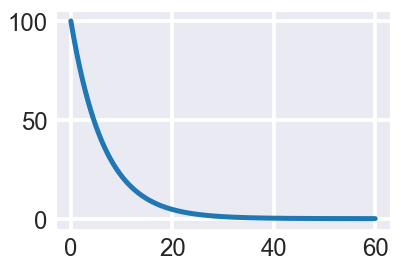

In [23]:
y = np.logspace(np.log10(100), np.log10(0.01), 60*100)
x = np.arange(len(y))/100
print(x)
plt.plot(x, y)

In [24]:
speeds = {
    'RL': [],
    'RR': [],
    'RAND': [],
    'RL-TEST': []
}

for instance in rand_data.keys():
    time = average_rl_times_train[instance]
    x_idx = 0
    try:
        while time > x[x_idx]:
            x_idx += 1
        speeds['RL'].append(y[x_idx])
    except IndexError:
        speeds['RL'].append(0)
    
    
    try:
        time = average_rl_times_test[instance]
        x_idx = 0
        while time > x[x_idx]:
            x_idx += 1
        speeds['RL-TEST'].append(y[x_idx])
    except IndexError:
        speeds['RL-TEST'].append(0)
    
    
    try:
        time = perm_instance_data_time[best_permuatation][instance]
        x_idx = 0
        while time > x[x_idx]:
            x_idx += 1
        speeds['RR'].append(y[x_idx])
    except IndexError:
        speeds['RR'].append(0)
    
    
    try:
        time = rand_data_time[instance]
        x_idx = 0
        while time > x[x_idx]:
            x_idx += 1
        speeds['RAND'].append(y[x_idx])
    except IndexError:
        speeds['RAND'].append(0)

for key in speeds:
    print(key, np.mean(speeds[key]))

RL 85.04939382540341
RR 79.80587041346777
RAND 76.78428311214924
RL-TEST 78.06347677976328


<BR><BR><BR><BR><BR><BR><BR>

In [25]:
all_times = np.array(
    [[int(inst.replace('prob', '').replace('.pddl', '')),
      average_rl_times_test[inst],
      perm_instance_data_time[best_permuatation][inst],
      rand_data_time[inst]]
     for inst in rand_data.keys()
    ])
all_times

array([[1.00000000e+00, 4.63726735e-01, 2.96431541e-02, 3.83601952e-02],
       [2.00000000e+00, 1.64128038e+00, 4.03198719e-02, 4.66581869e-02],
       [3.00000000e+00, 5.77168024e-01, 7.30769157e-02, 8.64935875e-02],
       [4.00000000e+00, 3.35204784e-01, 9.84717846e-02, 8.59454727e-02],
       [5.00000000e+00, 5.06137156e-01, 9.35315132e-02, 1.24344025e-01],
       [6.00000000e+00, 5.00866592e-01, 5.90092182e-02, 6.71232748e-02],
       [7.00000000e+00, 1.92897247e+00, 2.39417839e-01, 1.90057197e+00],
       [8.00000000e+00, 1.47618750e+00, 8.12870502e-02, 9.72909164e-02],
       [9.00000000e+00, 1.20363386e+00, 2.83759594e-01, 3.33863649e-01],
       [1.00000000e+01, 1.20783402e+00, 1.13294506e-01, 1.62218304e-01],
       [1.10000000e+01, 4.94727333e-01, 3.32393599e-01, 4.02665048e-01],
       [1.20000000e+01, 4.00575892e-01, 2.16955805e-01, 2.31713653e-01],
       [1.30000000e+01, 3.17739427e-01, 3.54583263e-01, 5.48169847e-01],
       [1.40000000e+01, 5.00041682e-01, 4.99304295e

In [26]:
print('Average solve time per instance in sec')
print('  RL', '    RR', '  RAND')
print(np.around(np.mean(all_times[:, 1:], axis=0), decimals=3))

Average solve time per instance in sec
  RL     RR   RAND
[2.385 4.329 4.324]


In [27]:
# sorting instances by average solve time
inst_time = np.mean(all_times[:, 1:], axis=1)
sort_indx = np.argsort(inst_time)
print(all_times[sort_indx])

[[4.00000000e+00 3.35204784e-01 9.84717846e-02 8.59454727e-02]
 [1.00000000e+00 4.63726735e-01 2.96431541e-02 3.83601952e-02]
 [6.00000000e+00 5.00866592e-01 5.90092182e-02 6.71232748e-02]
 [5.00000000e+00 5.06137156e-01 9.35315132e-02 1.24344025e-01]
 [3.00000000e+00 5.77168024e-01 7.30769157e-02 8.64935875e-02]
 [1.20000000e+01 4.00575892e-01 2.16955805e-01 2.31713653e-01]
 [1.30000000e+01 3.17739427e-01 3.54583263e-01 5.48169847e-01]
 [1.10000000e+01 4.94727333e-01 3.32393599e-01 4.02665048e-01]
 [1.70000000e+01 4.00027895e-01 5.15637302e-01 5.62894921e-01]
 [1.00000000e+01 1.20783402e+00 1.13294506e-01 1.62218304e-01]
 [8.00000000e+00 1.47618750e+00 8.12870502e-02 9.72909164e-02]
 [2.00000000e+00 1.64128038e+00 4.03198719e-02 4.66581869e-02]
 [1.40000000e+01 5.00041682e-01 4.99304295e-01 8.09228559e-01]
 [9.00000000e+00 1.20363386e+00 2.83759594e-01 3.33863649e-01]
 [2.10000000e+01 9.64166427e-01 8.14750576e-01 9.43560481e-01]
 [1.50000000e+01 1.03329206e+00 9.40780544e-01 8.929639

RL is only based on test results


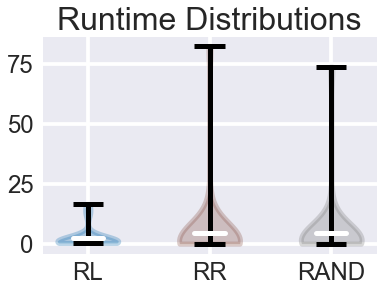

In [28]:
vps = plt.violinplot(all_times[sort_indx, 1:],
                    showmeans=True, showmedians=False)
plt.title('Runtime Distributions')
ax = plt.gca()
ax.set_xticklabels(['', 'RL', 'RR', 'RAND'])


for pc, c in zip(vps['bodies'],
                 [colors['RL'], colors['RR'], colors['RAND'], colors['SOP']]):
    pc.set_facecolor(c)
    pc.set_edgecolor(c)
    pc.set_linewidth(5)
    
for partname in ('cbars','cmins','cmaxes'):
    vp = vps[partname]
    vp.set_edgecolor('black')
    vp.set_linewidth(5)
vp = vps['cmeans']
vp.set_linewidth(0)
xy = [[l.vertices[:,0],[l.vertices[0,1],l.vertices[0,1]]] for l in vp.get_paths()]
xy = np.array(xy)
for (x, y) in xy:
    ax.plot(x, y, c='white', linewidth=5)

print('RL is only based on test results')

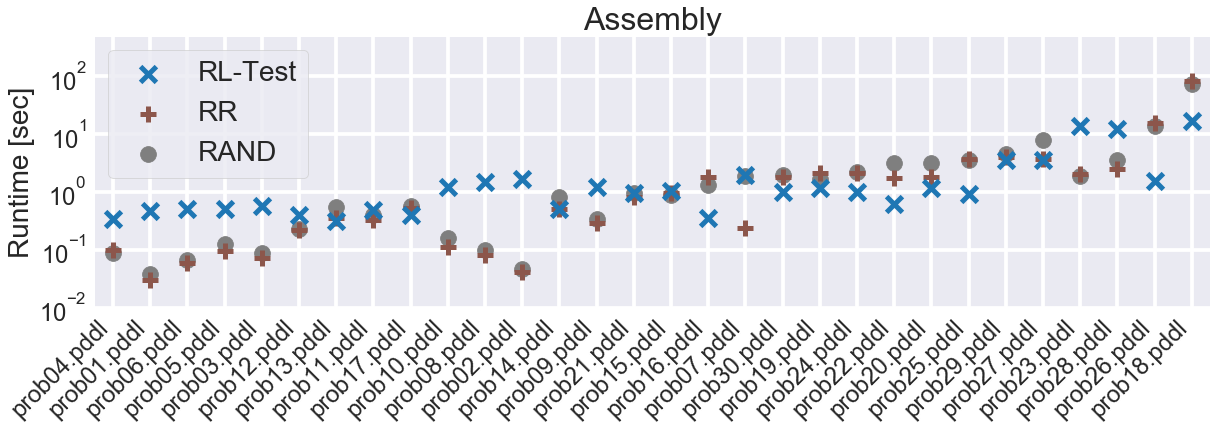

In [29]:
fig = plt.figure(figsize=(20, 5))
plt.scatter(np.arange(len(sort_indx)), all_times[sort_indx, 1],
            label='RL-Test', marker='x', s=250, zorder=3,
            color=colors['RL']
           )
plt.scatter(np.arange(len(sort_indx)), all_times[sort_indx, 2],
            label='RR', marker='+', s=250, zorder=2,
            color=colors['RR']
           )
plt.scatter(np.arange(len(sort_indx)), all_times[sort_indx, 3],
            label='RAND', marker='o', s=250, zorder=1,
            color=colors['RAND']
           )
plt.legend()
plt.semilogy()
plt.ylim([0.01, 500])
plt.xlim([-.5, len(sort_indx) - .5])
plt.ylabel('Runtime [sec]')
plt.title('Assembly')
# ax = plt.gca()
# ax.set_xticks(np.arange(len(sort_indx)))
# ax.set_xticklabels(list(rand_data_time.keys()))
# plt.xticks(rotation=45)
plt.xticks(np.arange(len(sort_indx)),
           np.array(list(rand_data_time.keys()))[sort_indx],
           rotation=45,
           ha='right'
          )
plt.savefig('assembly_runtimes.pdf', bbox_inches='tight')
plt.show()

<BR><BR><BR><BR><BR><BR><BR>

In [30]:
import glob
import re
regex = re.compile("(instance.*pddl|Expanded.*state)")
log_files_dir = "/mhome/biedenka/rl-plan-tmp/experiments/assembly_v3/"
file_str = "old_feats_wide_long_{:d}_val/*/*/old_feats_wide_long_*{:d}*fd*{:d}*{:d}-*.log"
test_dir_str = "old_feats_wide_long_{:d}_val/*"

# Tak ids <= 20 are training evaluations
# otherwise they are test evaluations
# there are two validation runs for the test data as the first accidentally also
# accessed the training instances. So we have to ignore the first

test_expansions = {}
train_expansions = {}
for split in range(1, 6):
    for seed in range(1, 11):
            print(file_str.format(split, split, UNITS, seed))
            # we have to make sure we don't accidentally load the wrong test validation
            fs = sorted(glob.glob(os.path.join(
                log_files_dir, file_str.format(split, split, UNITS, seed))))
            all_test_data_dirs = sorted(glob.glob(os.path.join(
                log_files_dir, test_dir_str.format(split)
            )))
            correct_test_data_dir = None
            for dir_ in all_test_data_dirs:
                if len(os.listdir(dir_)) <= 20:
                    correct_test_data_dir = os.path.basename(dir_)
            for f in fs:
#                 print(f)
                tid = int(f.split('_task_')[1].split('-')[0])
                TEST = tid > 20
                if TEST and not correct_test_data_dir in f:
                    continue
                n_insts = 0
                with open(f, 'r') as fh:
                    inst = None
                    ex = None
                    for line in fh:
                        result = regex.search(line)
                        if result:
                            res_str = result.group().split(' ')
                            if 'Expanded' in res_str[0]:
                                ex = int(res_str[1])
                            if 'instance' in res_str[0]:
                                n_insts += 1
                                inst = os.path.basename(res_str[1])
                        if inst and ex:
                            if TEST:
                                if inst not in test_expansions:
                                    test_expansions[inst] = []
                                test_expansions[inst].append(ex)
                            else:
                                if inst not in train_expansions:
                                    train_expansions[inst] = []
                                train_expansions[inst].append(ex)
                            inst = None
                            ex = None

old_feats_wide_long_1_val/*/*/old_feats_wide_long_*1*fd*200*1-*.log
old_feats_wide_long_1_val/*/*/old_feats_wide_long_*1*fd*200*2-*.log
old_feats_wide_long_1_val/*/*/old_feats_wide_long_*1*fd*200*3-*.log
old_feats_wide_long_1_val/*/*/old_feats_wide_long_*1*fd*200*4-*.log
old_feats_wide_long_1_val/*/*/old_feats_wide_long_*1*fd*200*5-*.log
old_feats_wide_long_1_val/*/*/old_feats_wide_long_*1*fd*200*6-*.log
old_feats_wide_long_1_val/*/*/old_feats_wide_long_*1*fd*200*7-*.log
old_feats_wide_long_1_val/*/*/old_feats_wide_long_*1*fd*200*8-*.log
old_feats_wide_long_1_val/*/*/old_feats_wide_long_*1*fd*200*9-*.log
old_feats_wide_long_1_val/*/*/old_feats_wide_long_*1*fd*200*10-*.log
old_feats_wide_long_2_val/*/*/old_feats_wide_long_*2*fd*200*1-*.log
old_feats_wide_long_2_val/*/*/old_feats_wide_long_*2*fd*200*2-*.log
old_feats_wide_long_2_val/*/*/old_feats_wide_long_*2*fd*200*3-*.log
old_feats_wide_long_2_val/*/*/old_feats_wide_long_*2*fd*200*4-*.log
old_feats_wide_long_2_val/*/*/old_feats_wide_lo

In [31]:
print('Expansions vs. RL-Cost/Plan-Cost')
print('TRAIN')
for x in sorted(train_expansions):
    train_expansions[x] = np.mean(train_expansions[x])
    b, c = train_expansions[x], average_rl_train_results[x]
    print(x, "{:>7.2f} {:>7.2f}".format(b, c))
print()
print('TEST')
for x in sorted(test_expansions):
    test_expansions[x] = np.mean(test_expansions[x])
    b, c = test_expansions[x], average_rl_test_results[x]
    print(x, "{:>7.2f} {:>7.2f}".format(b, c))

Expansions vs. RL-Cost/Plan-Cost
TRAIN
prob01.pddl   33.08   32.08
prob02.pddl   42.02   41.03
prob03.pddl   78.50   77.50
prob04.pddl   41.40   40.40
prob05.pddl   54.50   53.50
prob06.pddl   39.00   38.00
prob07.pddl  123.22  122.25
prob08.pddl   60.62   59.83
prob09.pddl  154.18  153.18
prob10.pddl   66.95   65.95
prob11.pddl  128.57  127.58
prob12.pddl   67.88   66.88
prob13.pddl  136.97  135.98
prob14.pddl  157.57  156.58
prob15.pddl  146.12  145.22
prob16.pddl  114.88  113.88
prob17.pddl  103.00  102.67
prob18.pddl 4029.62 4028.65
prob19.pddl  269.00  268.68
prob20.pddl  169.30  168.40
prob21.pddl   86.67   85.68
prob22.pddl  322.73  321.73
prob23.pddl  167.95  167.95
prob24.pddl  162.93  162.10
prob25.pddl  256.48  256.02
prob26.pddl  734.27  733.27
prob27.pddl  280.75  279.88
prob28.pddl  242.38  241.38
prob29.pddl  322.52  321.52
prob30.pddl  169.15  168.15

TEST
prob01.pddl   34.30   33.40
prob02.pddl   40.40   39.40
prob03.pddl   78.00   77.00
prob04.pddl   43.50   42.50
pro

Average guidance of RL-TEST agent on Assembly
1.5853161738766564


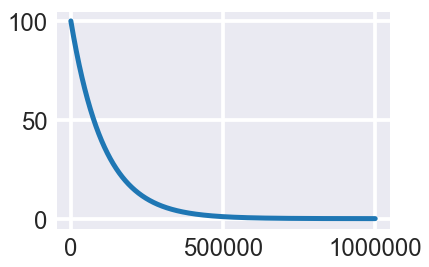

In [32]:
print('Average guidance of RL-TEST agent on Assembly')
yy = np.logspace(np.log10(100), np.log10(0.01), 10**6)
xx = np.arange(len(yy)) + 100
# print(xx)
plt.plot(xx, yy)

guidance = []
for instance in test_expansions:
    exps = test_expansions[instance]
    x_idx = 0
    try:
        while exps > xx[x_idx]:
            x_idx += 1
        guidance.append(y[x_idx])
    except IndexError:
        guidance.append(0)
print(np.mean(guidance))

<BR><BR><BR><BR><BR><BR><BR><BR><BR><BR><BR><BR><BR><BR><BR><BR><BR><BR><BR><BR><BR><BR><BR><BR><BR><BR><BR><BR><BR><BR><BR><BR><BR><BR><BR><BR><BR><BR><BR><BR>
I realized with the splits we used above we didn't correctly split into disjoint training and test sets which is why I created a new split using sklearn

from sklearn.model_selection import train_test_split, RepeatedKFold
import shutil
data_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'ipc-benchmarks',
                                         'assembly-crossvalidation', 'all'))

X=np.array(list(range(1,31)))
rkf=RepeatedKFold(n_splits=5, n_repeats=1, random_state=0)
splits = {}
idx = 1
for train, test in rkf.split(X):
    splits[idx] = {'train': [], 'test': []}
    os.mkdir(os.path.join(data_path, 'split{:>d}'.format(idx)))
    os.mkdir(os.path.join(data_path, 'split{:>d}'.format(idx), 'train'))
    os.mkdir(os.path.join(data_path, 'split{:>d}'.format(idx), 'test'))
    for train_idx in train:
        splits[idx]['train'].append(str(os.path.join(
            data_path, 'prob{:>02d}.pddl'.format(X[train_idx]))))
        shutil.copyfile(splits[idx]['train'][-1],
                        os.path.join(
                            data_path, 'split{:>d}'.format(idx),
                            'train', 'prob{:>02d}.pddl'.format(X[train_idx])))
    
    for test_idx in test:
        splits[idx]['test'].append(str(os.path.join(
            data_path, 'prob{:>02d}.pddl'.format(X[test_idx]))))
        shutil.copyfile(splits[idx]['test'][-1],
                        os.path.join(data_path, 'split{:>d}'.format(idx),
                                     'test', 'prob{:>02d}.pddl'.format(X[test_idx])))
    print(X[train])
    print(X[test])
    print()
    idx += 1

splits

with open('splits.json', 'w') as hf:
    json.dump(splits, hf)

os.getcwd()